In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Load Data
data = pd.read_csv('cimb_stock.csv')
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)
data = data[['Price']]

In [3]:
# Scaling Data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Price'] = scaler.fit_transform(data[['Price']])

# Creating Sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(data['Price'].values, seq_length)

In [4]:
# Splitting Data (Train, Validation, Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)

In [5]:
# LSTM Model with Dropout to Prevent Overfitting
lstm_model = Sequential([
    LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=100),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
# Training Model with Validation Set
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32)

# Making Predictions
y_pred_lstm = lstm_model.predict(X_test)

# Inverse Transform Predictions to Original Scale
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Hybrid Model (Weighted Average of LSTM and Linear Regression)
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train.reshape(X_train.shape[0], -1), y_train)

y_pred_lr = lr_model.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_lr = scaler.inverse_transform(y_pred_lr.reshape(-1, 1))

# Hybrid Model (70% LSTM, 30% Linear Regression)
y_pred_hybrid = (0.7 * y_pred_lstm) + (0.3 * y_pred_lr)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - loss: 0.0616 - val_loss: 0.0053
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - loss: 0.0039 - val_loss: 0.0048
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss: 0.0021 - val_loss: 0.0016
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 10/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 12/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - loss:

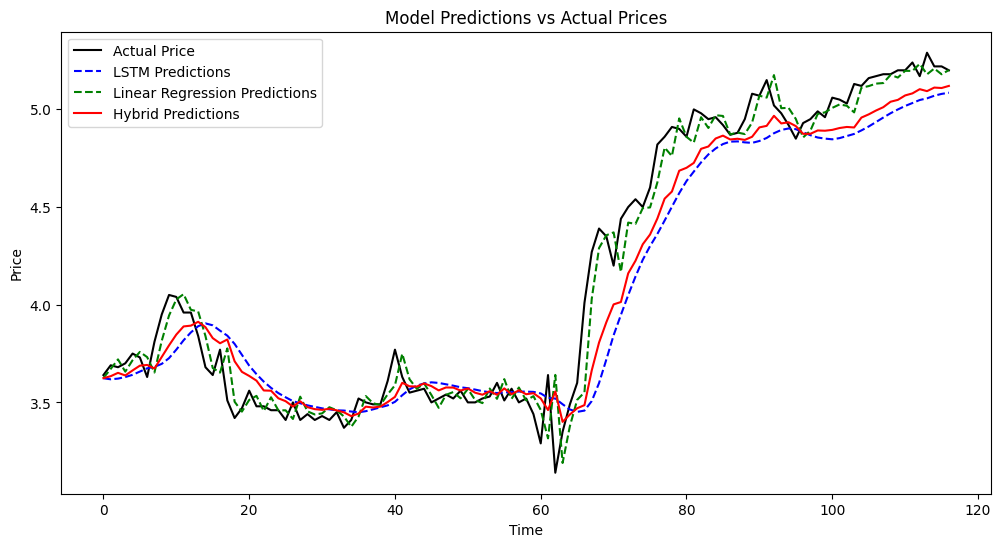

In [7]:
# Plot Results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test, color="black", label="Actual Price")
plt.plot(y_pred_lstm, color="blue", linestyle="dashed", label="LSTM Predictions")
plt.plot(y_pred_lr, color="green", linestyle="dashed", label="Linear Regression Predictions")
plt.plot(y_pred_hybrid, color="red", label="Hybrid Predictions")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.title("Model Predictions vs Actual Prices")
plt.show()